In [1]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from tqdm import tqdm
from matplotlib.lines import Line2D

from cryptic_rnn import *

# Functions

In [2]:
def plotNNs(loss_arrays, title='', labels=['train', 'test1', 'test2'],  colors=['green', 'yellow', 'red']):

    fig, axs = plt.subplots()
    for i, arr in enumerate(loss_arrays):
        x = np.arange(0,arr.shape[0],1)
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs.plot(x, mn, label = labels[i], color = colors[i])
        axs.fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = colors[i])
    
    axs.set_xlabel('epoch')
    axs.set_ylabel('loss')
    axs.legend()
    
    fig.suptitle(title, fontsize=10)


def run_exp(trainseqs_old_b ,trainseqs_old_p, testseqs_old, cue_dict):

    all_syms = list(cue_dict.keys())
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    input_vals.sort() # sort values (so A is smallest)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    # load data for primitive training
    trainset_b = []
    for trainb in trainseqs_old_b:
        trainseqs = change_dict(trainb, cue_dict)
        train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
        trainset_b.append(DataLoader(train_inputs, batch_size=batchsize, shuffle=True))
    
    trainset_p = []
    for trainp in trainseqs_old_p:
        trainseqs = change_dict(trainp, cue_dict)
        train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
        trainset_p.append(DataLoader(train_inputs, batch_size=batchsize, shuffle=True))
    
    test_sets_all = []
    for tt in testseqs_old:
        testseqs = change_dict(tt, cue_dict)
        test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
        test_sets_all.append(DataLoader(test_inputs, batch_size=batchsize, shuffle=True))

    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers, xavier_gain)
    model_b = copy.deepcopy(model)
    model_p = copy.deepcopy(model)
    criterion = nn.MSELoss()
    
    optimizer = torch.optim.Adam(model_b.parameters(), lr=learningRate)
    lossb, testloss_b = np.empty((0,1)), np.empty((0, len(testseqs_old)+1))
    for trainb in trainset_b:
        loss_step, test_loss_step = run_loss(model_b, optimizer, criterion, trainb, [trainb] + test_sets_all, epochs, hidden_size)
        lossb = np.vstack([lossb, loss_step])
        testloss_b = np.vstack([testloss_b, test_loss_step])
        
    optimizer = torch.optim.Adam(model_p.parameters(), lr=learningRate)
    lossp, testloss_p = np.empty((0,1)), np.empty((0, len(testseqs_old)+1))
    for trainp in trainset_p:
        loss_step, test_loss_step = run_loss(model_p,optimizer, criterion, trainp, [trainp] + test_sets_all, epochs, hidden_size)
        lossp = np.vstack([lossp, loss_step])
        testloss_p = np.vstack([testloss_p, test_loss_step])
    print(lossb)
    return {'cue_dict':cue_dict, 'test': test_sets_all,
           'loss_b':lossb, 'test_loss_b':testloss_b, 'mod_b': model_b,\
           'loss_p':lossp, 'test_loss_p':testloss_p, 'mod_p': model_p,}

def run_plot(trainseqs_b, trainseqs_p, testseqs, cue_dict):
    t1 = time.time()
    res  = Parallel(n_jobs = -1)(delayed(run_exp)(trainseqs_b, trainseqs_p,testseqs, cue_dict) for i in tqdm(range(num_sims)))
    t2 = time.time()
    print('run time: ', (t2-t1)/60)
    
    tests = [r['test'] for r in res]
    cue_dicts = [r['cue_dict'] for r in res]
    
    losses_b = np.hstack([r['loss_b'] for r in res])
    train_losses_b = np.array([r['test_loss_b'][:,0] for r in res]).T
    test_losses_b = np.array([r['test_loss_b'][:,1] for r in res]).T
    far_test_losses_b = np.array([r['test_loss_b'][:,2] for r in res]).T
    mods_b = [r['mod_b'] for r in res]

    losses_p = np.hstack([r['loss_p'] for r in res])
    train_losses_p = np.array([r['test_loss_p'][:,0] for r in res]).T
    test_losses_p = np.array([r['test_loss_p'][:,1] for r in res]).T
    far_test_losses_p = np.array([r['test_loss_p'][:,2] for r in res]).T
    mods_p = [r['mod_p'] for r in res]
        
    plotNNs([losses_b, test_losses_b, far_test_losses_b],labels=['train', 'test', 'transfer'], colors = ['green', 'orange', 'red'], title = 'balanced -no primitives')
    plotNNs([losses_p, test_losses_p, far_test_losses_p],labels=['train', 'test',  'transfer'], colors = ['green', 'orange', 'red'], title = 'with primitives')

    plt.figure()
    r2_b, dfs_b, _ = predcorr(mods_b, [t[0] for t in tests], hidden_size, plot_corr =True)
    plt.title('balanced-without primitives; r^2 = '+ str(round(r2_b, 3)))
    plt.figure()
    r2_p, dfs_p, _ = predcorr(mods_p, [t[0] for t in tests], hidden_size, plot_corr = True)
    plt.title('with primitives; r^2 = '+ str(round(r2_p, 3)))
    
    plt.figure()
    r2_b, dfs_b, _ = predcorr(mods_b, [t[1] for t in tests], hidden_size, plot_corr =True)
    plt.title('TRANSFER: balanced-without primitives; r^2 = '+ str(round(r2_b, 3)))
    plt.figure()
    r2_p, dfs_p, _ = predcorr(mods_p, [t[1] for t in tests], hidden_size, plot_corr = True)
    plt.title('TRANSFER: with primitives; r^2 = '+ str(round(r2_p, 3)))
 
    
    acc_df = pd.DataFrame({'train_b': train_losses_b[-1,:],'train_p': train_losses_p[-1,:].reshape(-1),\
                           'test_b': test_losses_b[-1,:],'test_p': test_losses_p[-1,:]})
    
    print('balanced loss', losses_b[-1,:].mean())
    print('primitives loss', losses_p[-1,:].mean())
    
    return {'mods_b':mods_b, 'mods_p':mods_p, 'losses_b_final': losses_b[-1,:], 'losses_p_final':losses_p[-1,:],\
            'res':res, 'tests': tests, 'cue_dicts': cue_dicts, 'acc_df':acc_df }


In [3]:
def run_loss(model,optimizer,criterion, train_data, test_data, epochs, hidden_size, verbose = False):
    
    loss_history = np.empty((0,1))
    test_loss_history = np.empty((0,len(test_data)))
    for epoch in range(epochs):
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history = np.vstack([loss_history, lossTotal])
        test_loss = test_modloss(model, test_data, criterion, hidden_size)
        test_loss_history = np.vstack([test_loss_history, test_loss])

    return loss_history, test_loss_history

def test_modloss(model, testdata, criterion, hidden_size=20):
    model.eval()
    losses_testset = []
    
    for t in testdata:
        loss_set = 0
        for x,y in t:
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                loss_set += criterion(y_hat, torch.tensor([y[i].item()])).item()
     
        losses_testset.append(loss_set)
        
    return losses_testset

def extract_ft(res1):
    
    acc_df = res1['acc_df']
    ft_idx = acc_df[(acc_df['train_b'] < 1) & (acc_df['train_p'] < 1)].index
    
    tests = [res1['tests'][i] for i in ft_idx]
    cue_dicts = [res1['cue_dicts'][i] for i in ft_idx]   
    mods_b = [res1['mods_b'][i] for i in ft_idx]
    mods_p = [res1['mods_p'][i] for i in ft_idx]
    
    return {'mods_b':mods_b, 'mods_p':mods_p,'tests': tests, 'cue_dicts': cue_dicts}


def generate_pos_pairs(op, inputs, cue_dict, shift):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    for s in range(shift):
        inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [('+', inputs1[i]), (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq

def generate_neg_pairs(op, inputs, cue_dict, shift):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    for s in range(shift):
        inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [('-', inputs1[i]), (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq


## RNN params

In [4]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005
xavier_gain = 0.0001

## running params
epochs = 1800
num_sims = 200

## Sequences

In [6]:
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print('cue_dict ',cue_dict)

pos_primitives = generate_pos_primitives(all_syms, cue_dict)
neg_primitives = generate_neg_primitives(all_syms, cue_dict)
pos_balanced = generate_balanced_primitives('+', all_syms, cue_dict)
neg_balanced = generate_balanced_primitives('-', all_syms, cue_dict)

trainseqs_add = generate_pos_pairs('+', all_syms, cue_dict, 1) + generate_pos_pairs('+', all_syms, cue_dict, 2)
trainseqs_sub = generate_neg_pairs('-', all_syms, cue_dict, 1) + generate_neg_pairs('-', all_syms, cue_dict, 2)
trainseqs_neg_add = generate_neg_pairs('+', all_syms, cue_dict, 1) + generate_neg_pairs('+', all_syms, cue_dict, 2)
trainseqs_pos_sub = generate_pos_pairs('-', all_syms, cue_dict, 1) + generate_pos_pairs('-', all_syms, cue_dict, 2)

testseqs_1 = generate_pos_trials('+', all_syms, all_syms, cue_dict) + generate_neg_trials('-', all_syms, all_syms, cue_dict)
testseqs_1 = [t for t in testseqs_1 if t not in trainseqs_add+trainseqs_sub]
testseqs_2 = generate_pos_trials('-', all_syms, all_syms, cue_dict) + generate_neg_trials('+', all_syms, all_syms, cue_dict)
testseqs_2 = [t for t in testseqs_2 if t not in trainseqs_pos_sub+trainseqs_neg_add]

testseqs_all = generate_pos_trials('+', all_syms, all_syms, cue_dict) +\
               generate_neg_trials('-', all_syms, all_syms, cue_dict) +\
               generate_pos_trials('-', all_syms, all_syms, cue_dict) +\
               generate_neg_trials('+', all_syms, all_syms, cue_dict)


cue_dict  {'A': 9, 'B': 8, 'C': 15, 'D': 12}


In [7]:
# add sub first

trainseqs_b1 = trainseqs_add + trainseqs_sub + generate_balanced_primitives('+', all_syms, cue_dict) + generate_balanced_primitives('-', all_syms, cue_dict)
trainseqs_b2 = trainseqs_b1 + trainseqs_neg_add + trainseqs_pos_sub

trainseqs_p1 = trainseqs_add  + trainseqs_sub + pos_primitives + neg_primitives
trainseqs_p2 = trainseqs_p1 + trainseqs_neg_add + trainseqs_pos_sub

trainseqs_b = [trainseqs_b1, trainseqs_b2]
trainseqs_p = [trainseqs_p1, trainseqs_p2]


100%|███████████████████████████████████████████| 32/32 [15:00<00:00, 28.13s/it]


run time:  20.215300047397612
balanced loss 942.3950366863531
primitives loss 1517.9140510964717


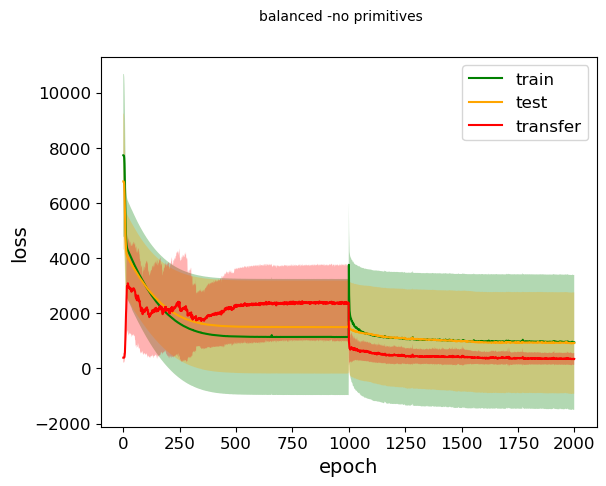

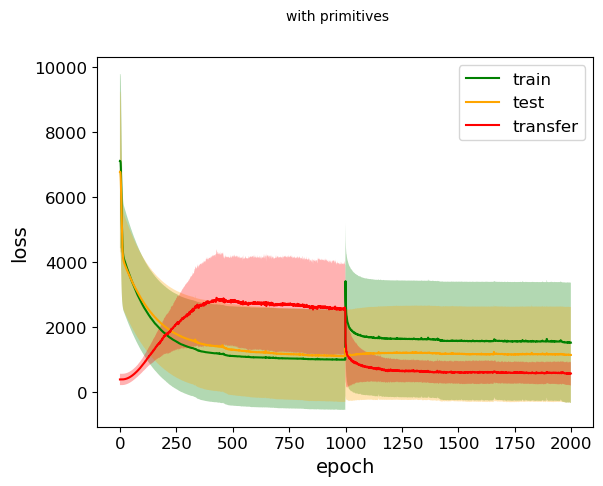

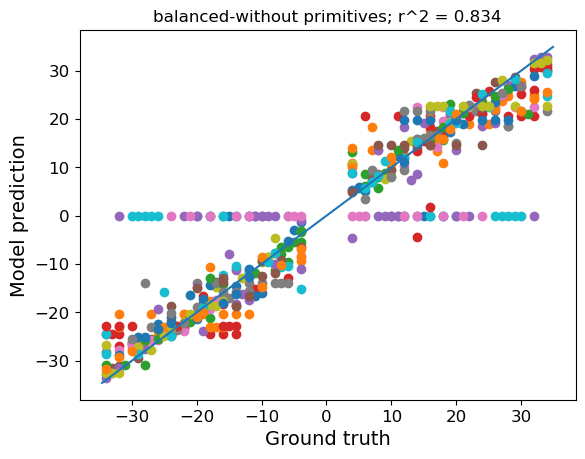

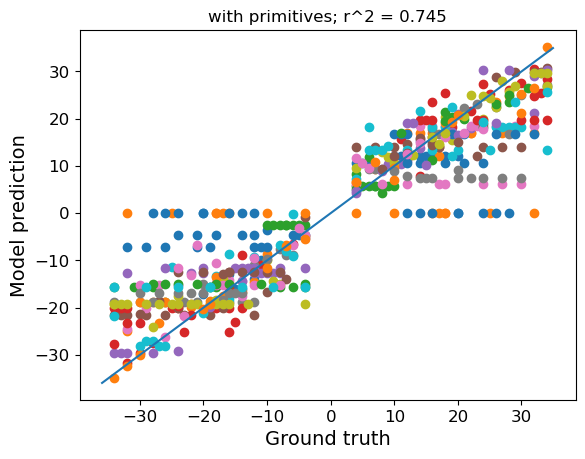

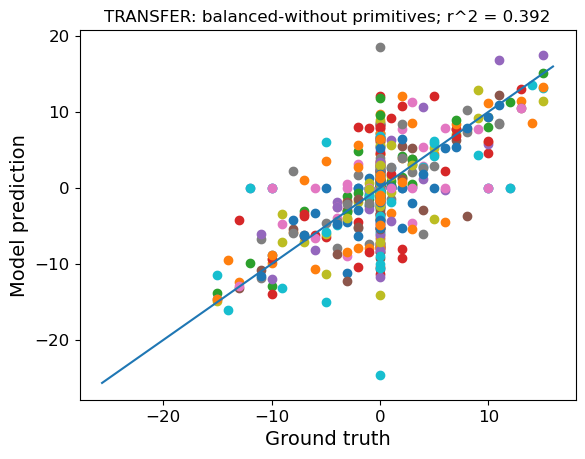

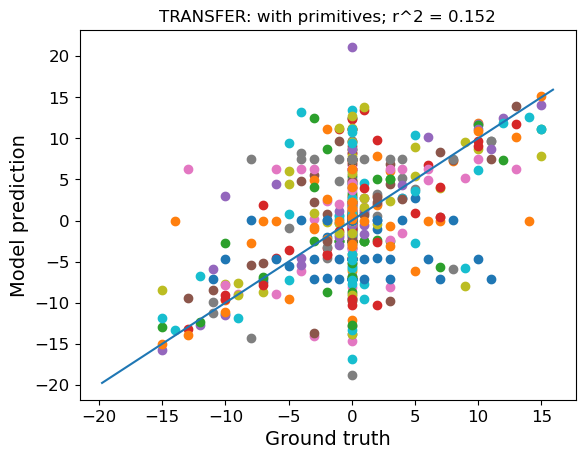

In [114]:
epochs = 1000
num_sims = 32
res2 = run_plot(trainseqs_b, trainseqs_p, [testseqs_1, testseqs_2], cue_dict)

In [115]:
## add sub second
trainseqs_b1 = trainseqs_neg_add + trainseqs_pos_sub  + generate_balanced_primitives('+', all_syms, cue_dict) + generate_balanced_primitives('-', all_syms, cue_dict)
trainseqs_b2 = trainseqs_b1 + trainseqs_add + trainseqs_sub

trainseqs_p1 = trainseqs_neg_add + trainseqs_pos_sub + pos_primitives + neg_primitives
trainseqs_p2 = trainseqs_p1 + trainseqs_add  + trainseqs_sub

trainseqs_b = [trainseqs_b1, trainseqs_b2]
trainseqs_p = [trainseqs_p1, trainseqs_p2]


100%|███████████████████████████████████████████| 32/32 [17:27<00:00, 32.74s/it]


run time:  23.23412341674169
balanced loss 3547.022736537553
primitives loss 2825.455403324069


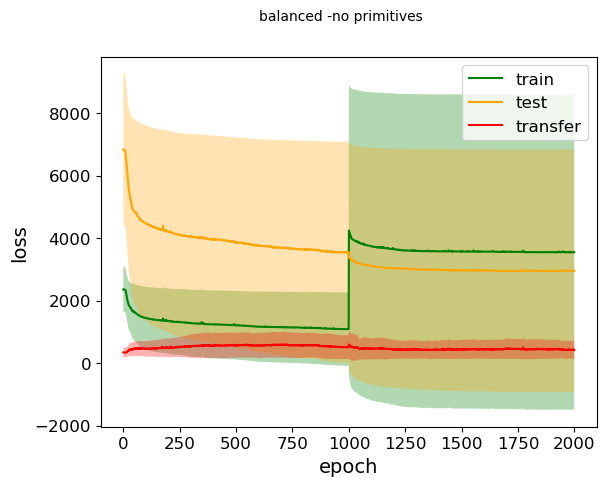

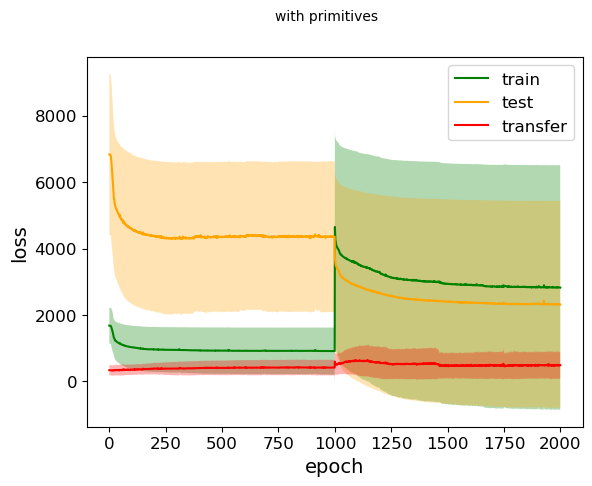

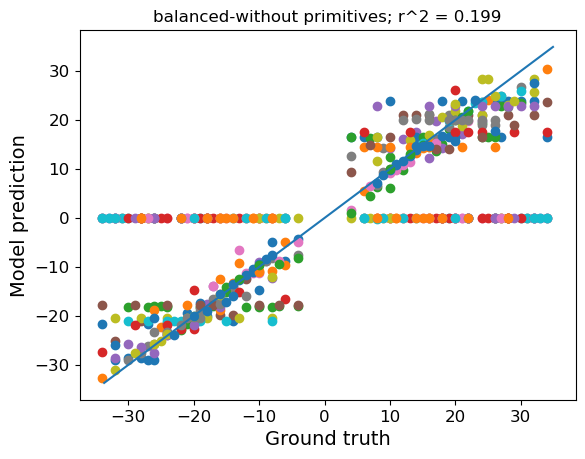

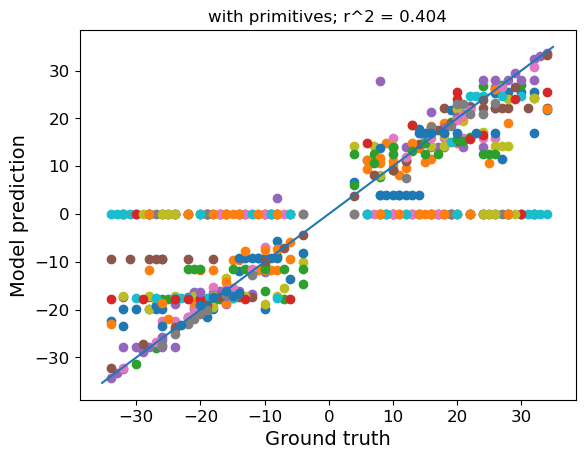

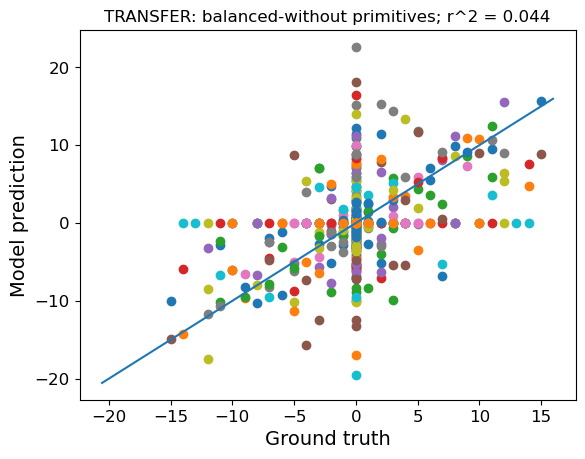

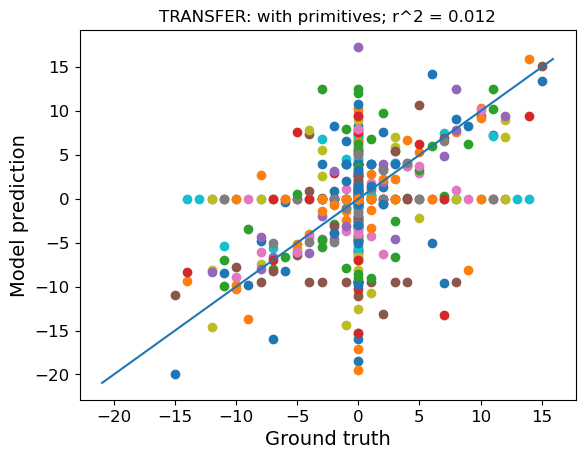

In [116]:
epochs = 1000
num_sims = 32
res2 = run_plot(trainseqs_b, trainseqs_p, [testseqs_1, testseqs_2], cue_dict)

In [117]:
trainseqs_b1 = trainseqs_pos_sub + trainseqs_neg_add + generate_balanced_primitives('+', all_syms, cue_dict) + generate_balanced_primitives('-', all_syms, cue_dict)
trainseqs_b3 = trainseqs_b1 + trainseqs_add + trainseqs_sub
trainseqs_b4 = trainseqs_b3 + trainseqs_pos_sub

trainseqs_p1 = trainseqs_pos_sub + trainseqs_neg_add + pos_primitives + neg_primitives
trainseqs_p3 = trainseqs_p1 + trainseqs_add + trainseqs_sub
trainseqs_p4 = trainseqs_p3 + trainseqs_pos_sub

trainseqs_b = [trainseqs_b1]
trainseqs_p = [trainseqs_p1]


100%|███████████████████████████████████████████| 32/32 [11:14<00:00, 21.08s/it]


run time:  15.021427166461944
balanced loss 559.7601913099297
primitives loss 904.4942647879323


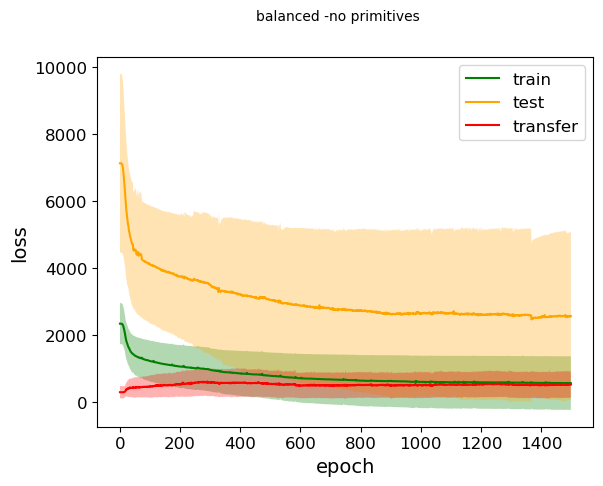

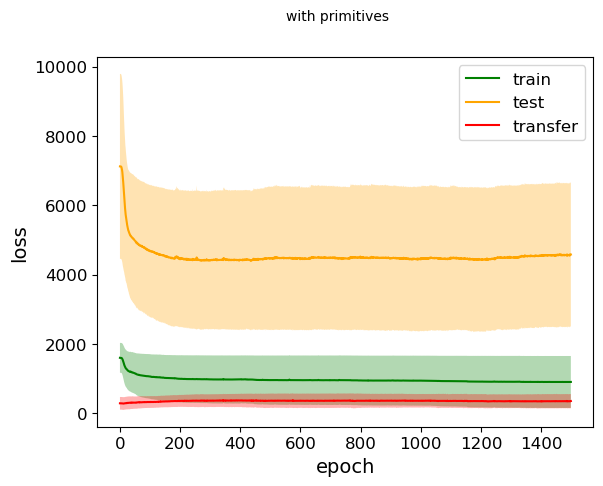

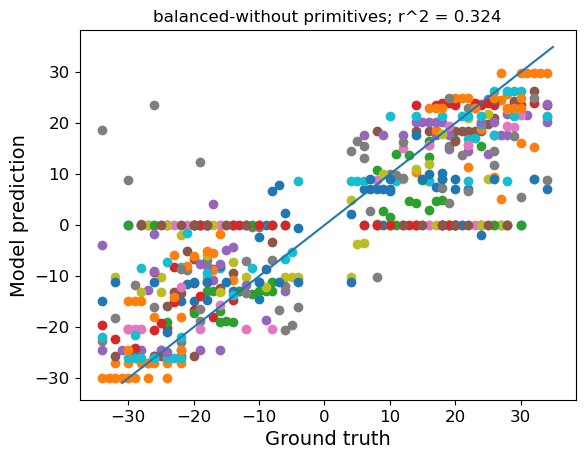

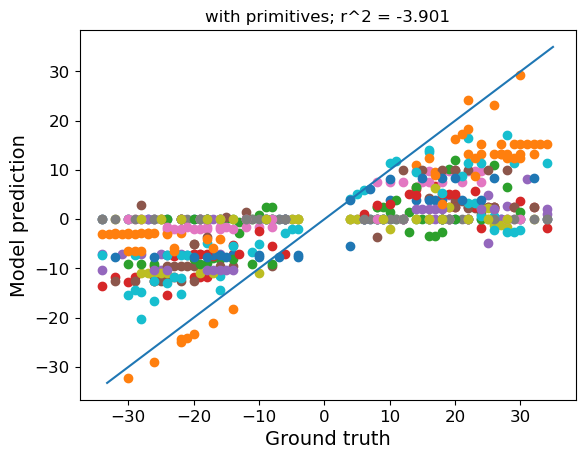

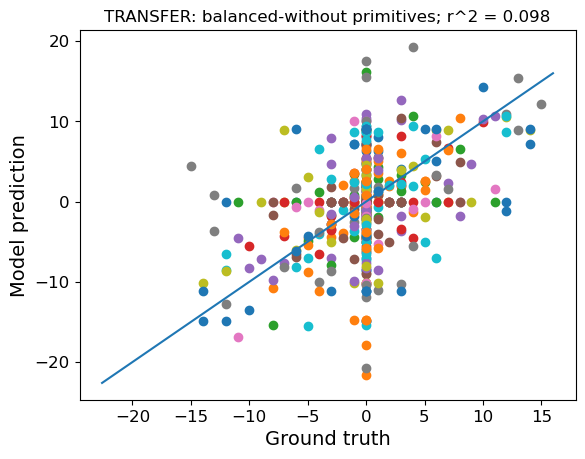

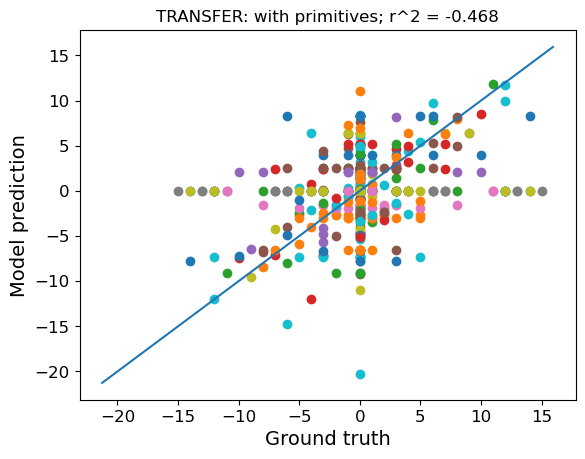

In [118]:
epochs = 1500
num_sims = 32
res2 = run_plot(trainseqs_b, trainseqs_p, [testseqs_1, testseqs_2], cue_dict)

In [119]:
trainseqs_b1 = trainseqs_add + trainseqs_sub + generate_balanced_primitives('+', all_syms, cue_dict) + generate_balanced_primitives('-', all_syms, cue_dict)
trainseqs_b3 = trainseqs_b1 + trainseqs_neg_add
trainseqs_b4 = trainseqs_b3 + trainseqs_pos_sub

trainseqs_p1 = trainseqs_add  + trainseqs_sub + pos_primitives + neg_primitives
trainseqs_p3 = trainseqs_p1 + trainseqs_neg_add
trainseqs_p4 = trainseqs_p3 + trainseqs_pos_sub

trainseqs_b = [trainseqs_b1, trainseqs_b3, trainseqs_b4]
trainseqs_p = [trainseqs_p1, trainseqs_p3, trainseqs_p4]


100%|███████████████████████████████████████████| 32/32 [25:49<00:00, 48.41s/it]


run time:  34.41990741888682
balanced loss 232.6395021525981
primitives loss 1233.2807431410065


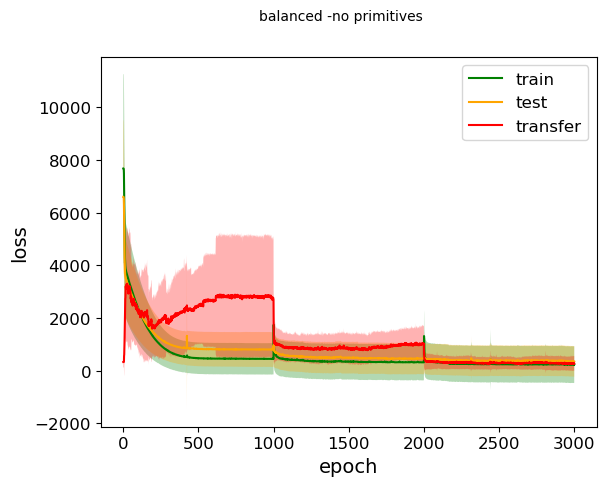

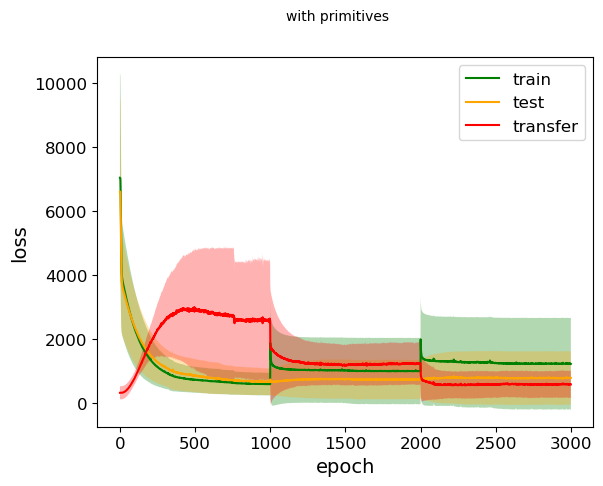

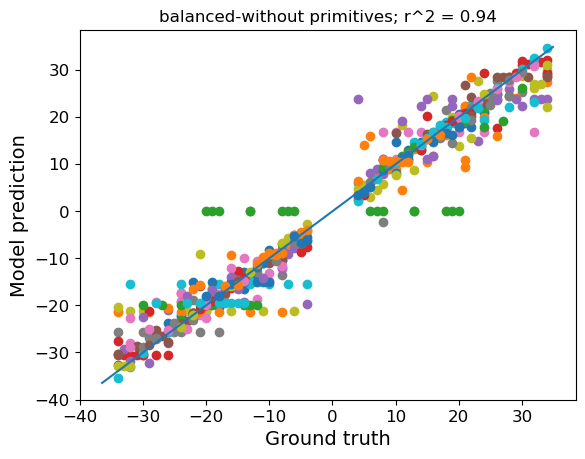

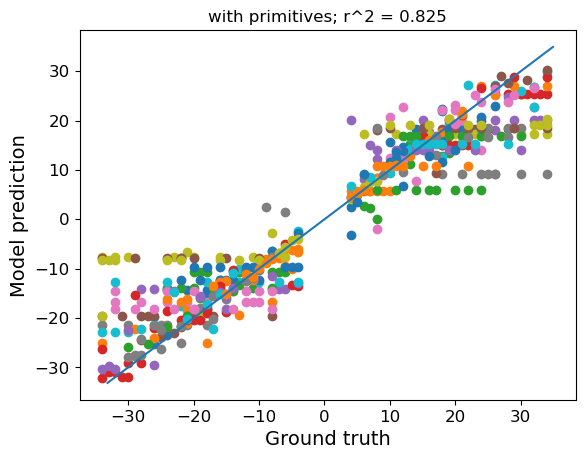

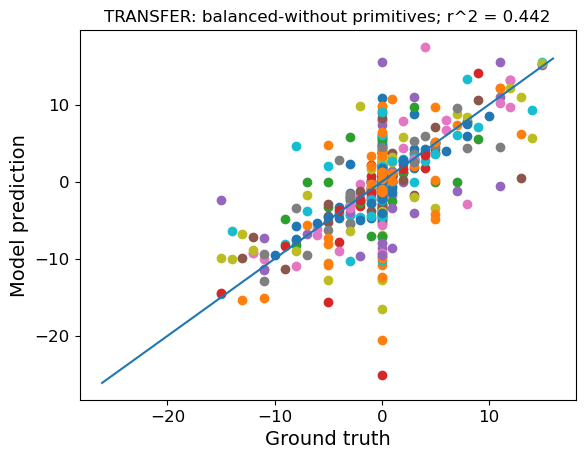

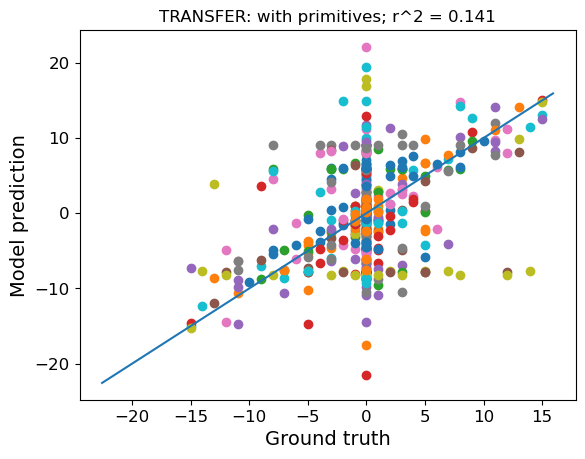

In [120]:
epochs = 1000
num_sims = 32
res2 = run_plot(trainseqs_b, trainseqs_p, [testseqs_1, testseqs_2], cue_dict)

100%|██████████████████████████████████████████| 32/32 [53:41<00:00, 100.67s/it]


run time:  71.55152542988459
balanced loss 1793.427707550068
primitives loss 2115.037962277046


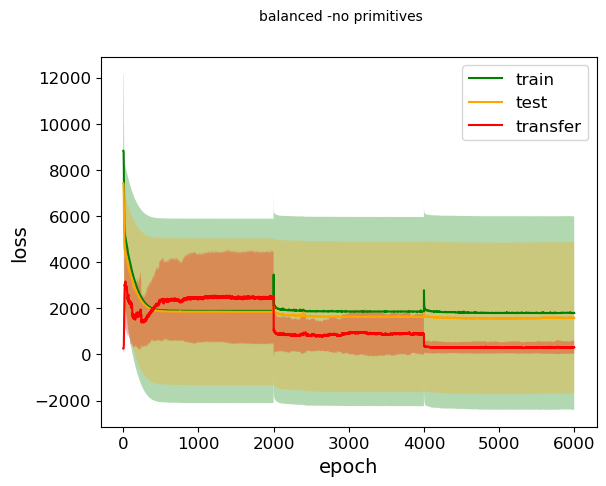

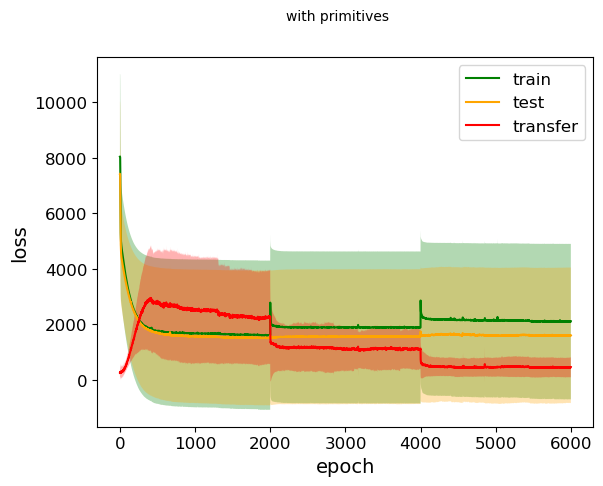

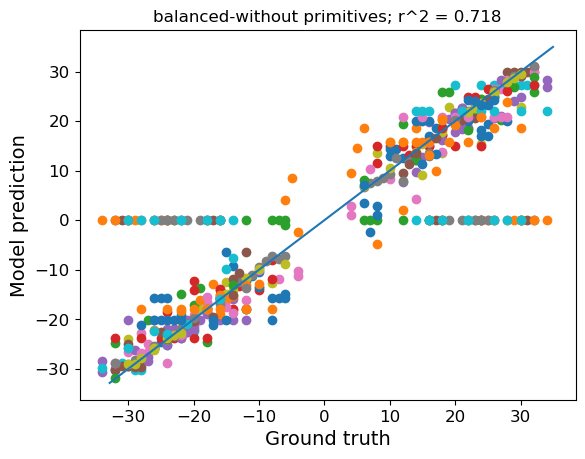

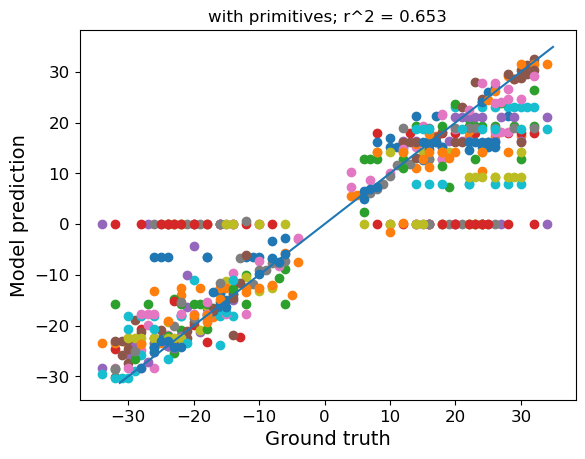

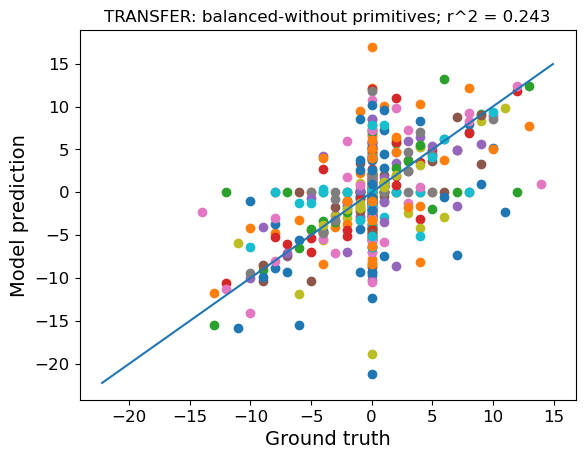

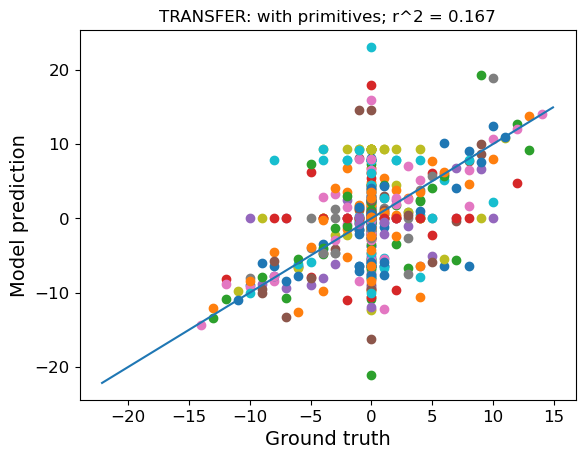

In [121]:
epochs = 2000
num_sims = 32
res2 = run_plot(trainseqs_b, trainseqs_p, [testseqs_1, testseqs_2], cue_dict)

In [122]:
trainseqs_b1 = trainseqs_pos_sub + trainseqs_neg_add + generate_balanced_primitives('+', all_syms, cue_dict) + generate_balanced_primitives('-', all_syms, cue_dict)
trainseqs_b3 = trainseqs_b1 + trainseqs_add + trainseqs_sub
trainseqs_b4 = trainseqs_b3 + trainseqs_pos_sub

trainseqs_p1 = trainseqs_pos_sub + trainseqs_neg_add + pos_primitives + neg_primitives
trainseqs_p3 = trainseqs_p1 + trainseqs_add + trainseqs_sub
trainseqs_p4 = trainseqs_p3 + trainseqs_pos_sub

trainseqs_b = [trainseqs_b1, trainseqs_b3]
trainseqs_p = [trainseqs_p1, trainseqs_p3]


100%|███████████████████████████████████████████| 32/32 [19:04<00:00, 35.78s/it]


run time:  24.98332682053248
balanced loss 3689.230241387553
primitives loss 3652.8386660308915


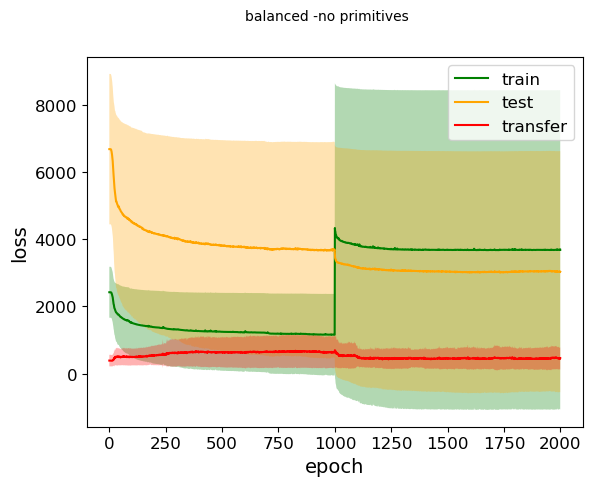

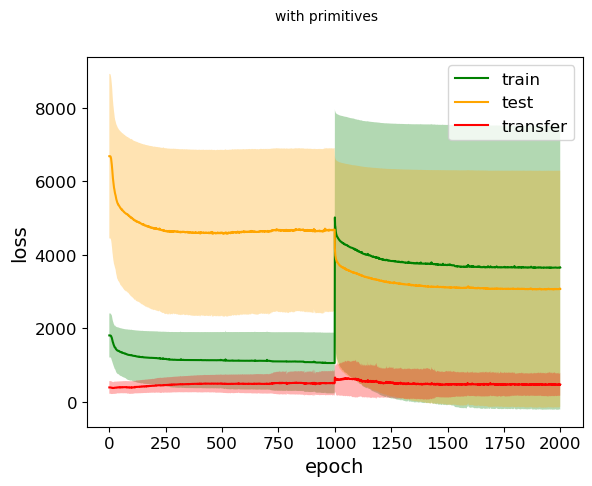

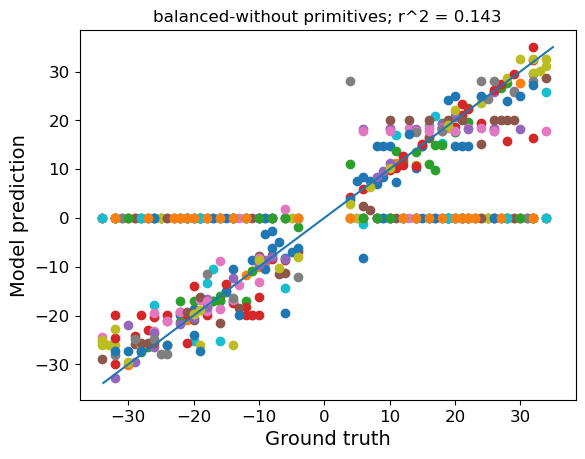

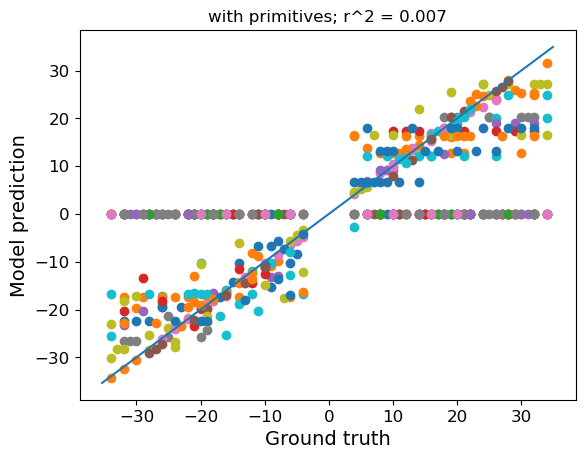

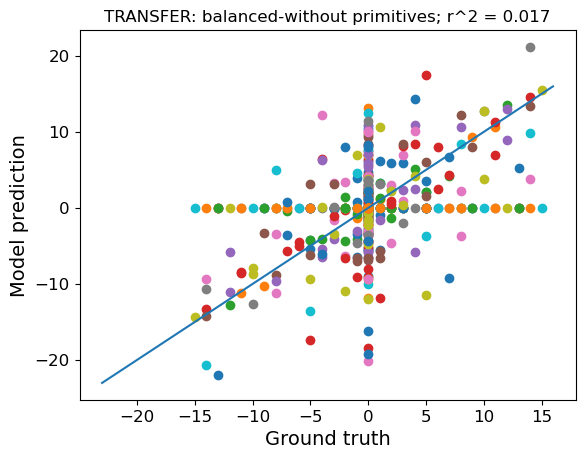

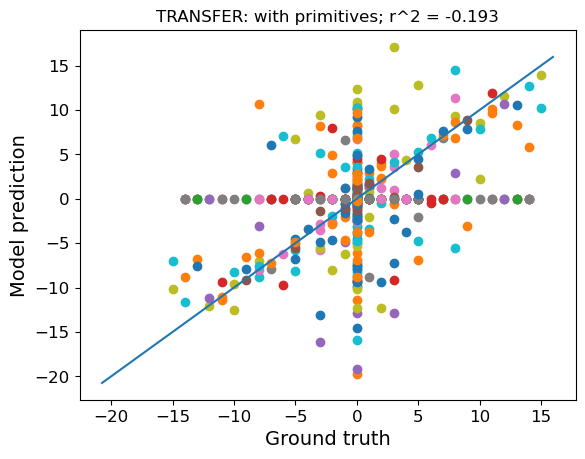

In [123]:
epochs = 1000
num_sims = 32
res2 = run_plot(trainseqs_b, trainseqs_p, [testseqs_1, testseqs_2], cue_dict)

In [124]:
trainseqs_b1 = trainseqs_add + generate_balanced_primitives('+', all_syms, cue_dict) 
trainseqs_b2 = trainseqs_b1 + trainseqs_sub + generate_balanced_primitives('-', all_syms, cue_dict)
trainseqs_b3 = trainseqs_b2 + trainseqs_neg_add
trainseqs_b4 = trainseqs_b3 + trainseqs_pos_sub

trainseqs_p1 = trainseqs_add  + pos_primitives 
trainseqs_p2 = trainseqs_p1 + trainseqs_sub + neg_primitives
trainseqs_p3 = trainseqs_p2 + trainseqs_neg_add
trainseqs_p4 = trainseqs_p3 + trainseqs_pos_sub

trainseqs_b = [trainseqs_b1, trainseqs_b2, trainseqs_b3, trainseqs_b4]
trainseqs_p = [trainseqs_p1, trainseqs_p2, trainseqs_p3, trainseqs_p4]


100%|███████████████████████████████████████████| 32/32 [13:51<00:00, 25.97s/it]


run time:  19.082210950056712
balanced loss 922.6564080092423
primitives loss 3082.829050312449


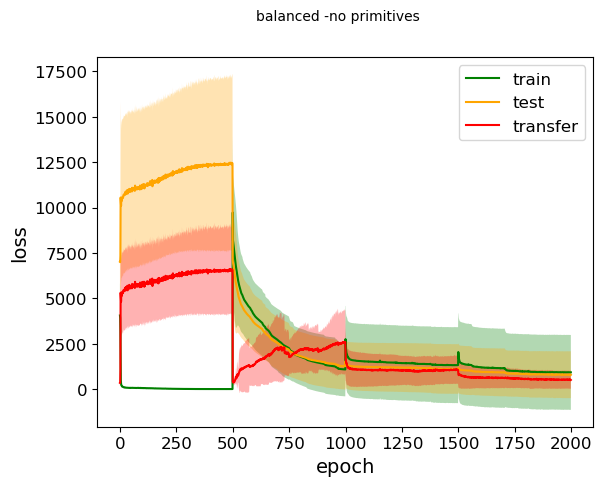

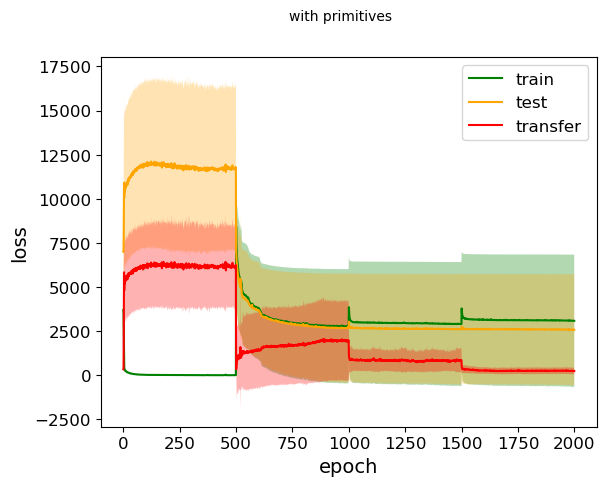

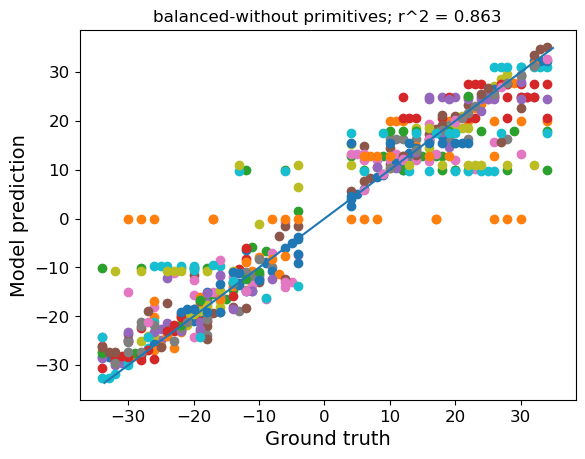

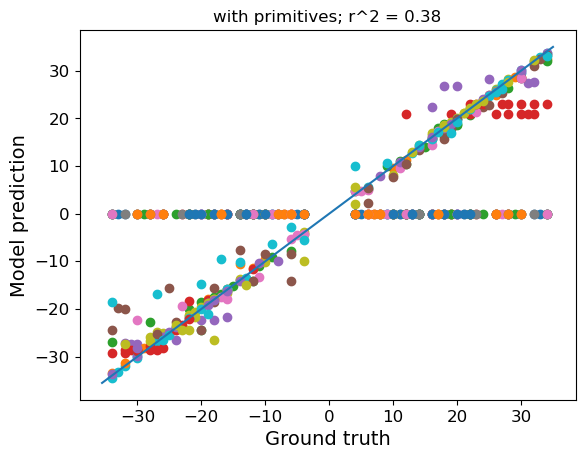

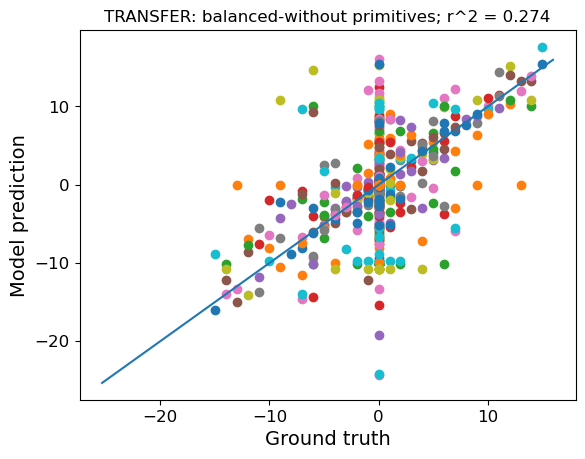

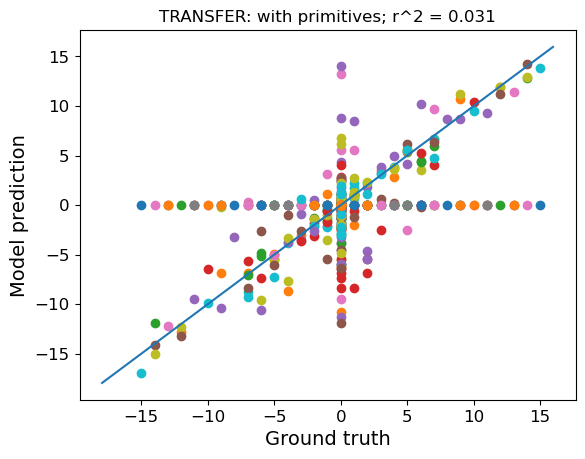

In [125]:
epochs = 500
num_sims = 32
res2 = run_plot(trainseqs_b, trainseqs_p, [testseqs_1, testseqs_2], cue_dict)

In [126]:
trainseqs_b1 = trainseqs_neg_add + generate_balanced_primitives('+', all_syms, cue_dict) + generate_balanced_primitives('-', all_syms, cue_dict)
trainseqs_b2 = trainseqs_b1 + trainseqs_pos_sub 
trainseqs_b3 = trainseqs_b2 + trainseqs_add
trainseqs_b4 = trainseqs_b3 + trainseqs_sub

trainseqs_p1 = trainseqs_neg_add  + pos_primitives + neg_primitives
trainseqs_p2 = trainseqs_p1 + trainseqs_pos_sub 
trainseqs_p3 = trainseqs_p2 + trainseqs_add
trainseqs_p4 = trainseqs_p3 + trainseqs_sub

trainseqs_b = [trainseqs_b1, trainseqs_b2, trainseqs_b3, trainseqs_b4]
trainseqs_p = [trainseqs_p1, trainseqs_p2, trainseqs_p3, trainseqs_p4]


100%|███████████████████████████████████████████| 32/32 [18:08<00:00, 34.03s/it]


run time:  22.904274694124858
balanced loss 643.6859758383636
primitives loss 2449.6359587226725


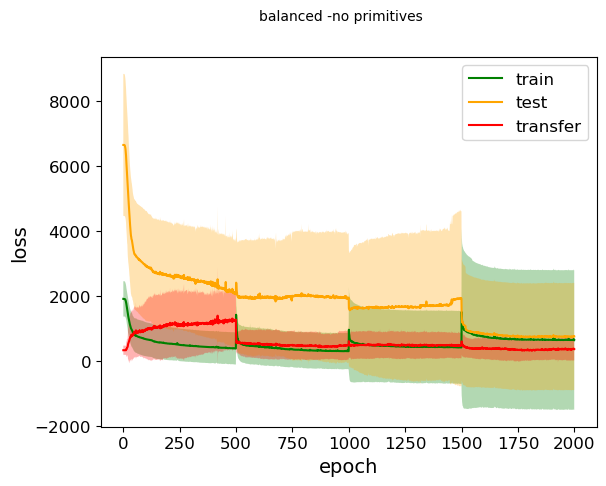

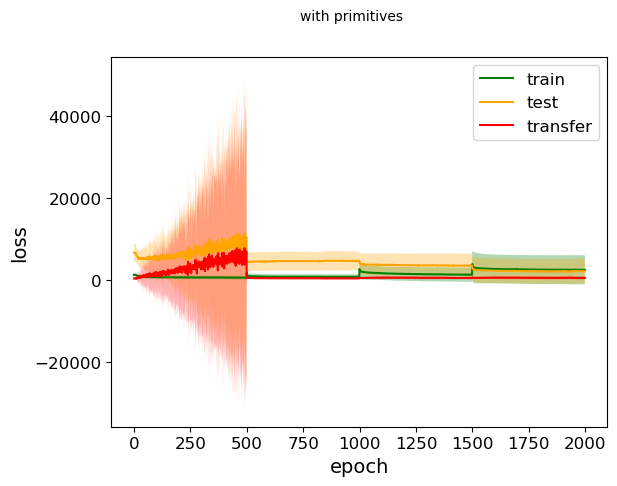

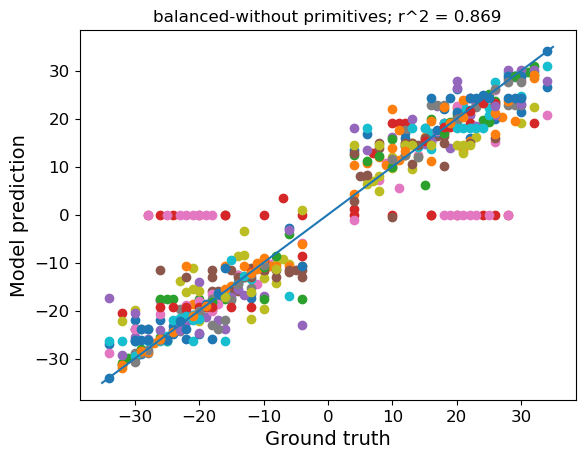

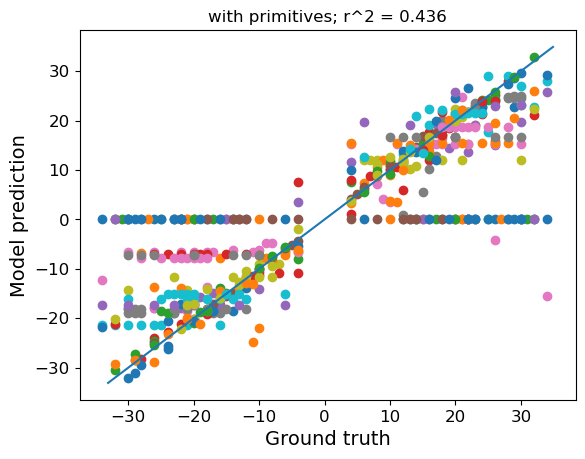

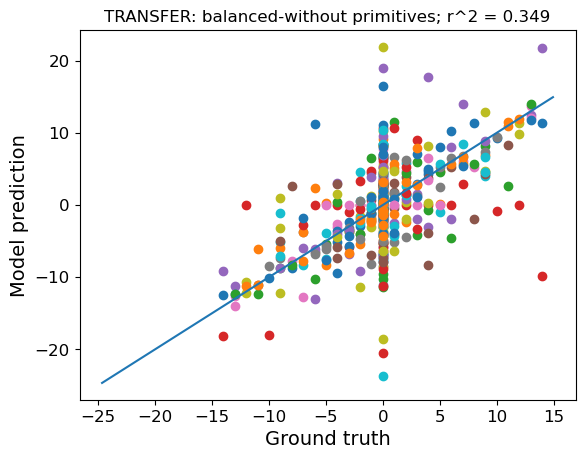

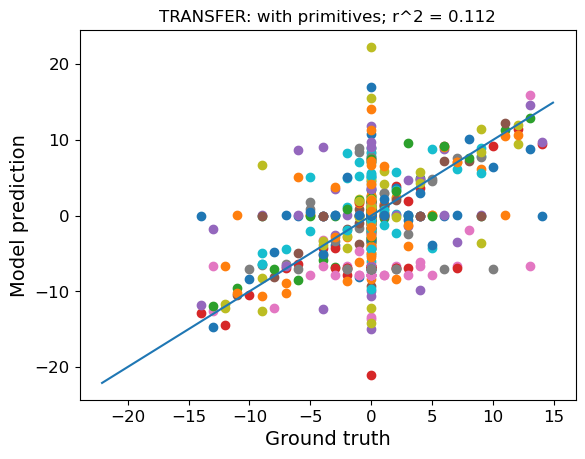

In [127]:
epochs = 500
num_sims = 32
res2 = run_plot(trainseqs_b, trainseqs_p, [testseqs_1, testseqs_2], cue_dict)

In [128]:
trainseqs_b1 = trainseqs_add + generate_balanced_primitives('+', all_syms, cue_dict) + generate_balanced_primitives('-', all_syms, cue_dict)
trainseqs_b2 = trainseqs_b1 + trainseqs_sub
trainseqs_b3 = trainseqs_b2 + trainseqs_neg_add
trainseqs_b4 = trainseqs_b3 + trainseqs_pos_sub

trainseqs_p1 = trainseqs_add  + pos_primitives + neg_primitives
trainseqs_p2 = trainseqs_p1 + trainseqs_sub 
trainseqs_p3 = trainseqs_p2 + trainseqs_neg_add
trainseqs_p4 = trainseqs_p3 + trainseqs_pos_sub

trainseqs_b = [trainseqs_b1, trainseqs_b2, trainseqs_b3, trainseqs_b4]
trainseqs_p = [trainseqs_p1, trainseqs_p2, trainseqs_p3, trainseqs_p4]


In [18]:
savedir = '../results/add_sub/staged_add'
with open(savedir, 'rb') as f:
    ress = pickle.load(f)

In [19]:
dms_all = calculate_RDMs(ress, testseqs_all, num_classes=22, batchsize=1,hidden_size=20, Tmax=4)

In [29]:
mat = np.array(dms_all['rdms_p'][2]).mean(axis=0)

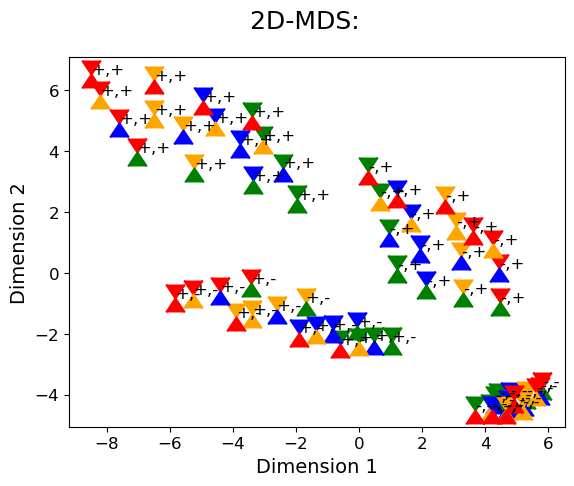

In [33]:
fig, ax = plt.subplots()

MDS_plot_single(ax, mat, testseqs_all, MDStype = 'MDS', min_dim=0)

In [34]:
mat = np.array(dms_all['rdms_b'][2]).mean(axis=0)

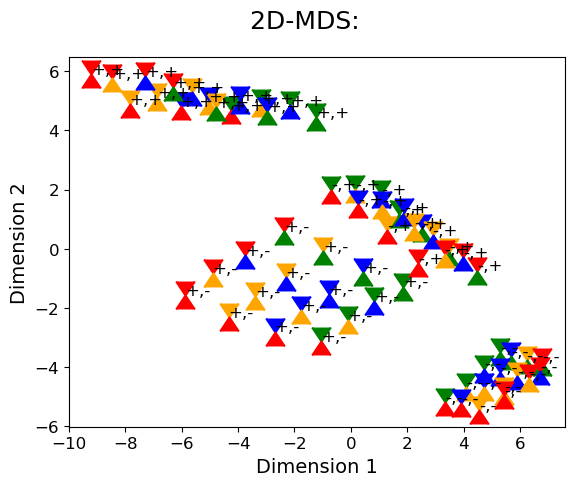

In [35]:
fig, ax = plt.subplots()

MDS_plot_single(ax, mat, testseqs_all, MDStype = 'MDS', min_dim=0)

In [28]:
pca = PCA(n_components=4)
pca_fit = pca.fit_transform(mat)
pca.explained_variance_ratio_


array([0.7744154 , 0.16366535, 0.02479244, 0.01349   ])

In [8]:
ca, cb, cc, cd = 'green', 'blue', 'orange', 'red'
colors1 = ([ca]*4 + [cb]*4 + [cc]*4 + [ cd]*4)*4
colors2 = (ca, cb, cc, cd)*16
textannot = ['+,+']*16 + ['-,-']*16 + ['+,-']*16 + ['-,+']*16 

msize = 12
legend_elements = [Line2D([0], [0], marker=6, color='w', markerfacecolor =ca, markersize=msize, label=' A _'),
                   Line2D([0], [0], marker=6, color='w', markerfacecolor =cb, markersize=msize, label=' B _'), 
                   Line2D([0], [0], marker=6, color='w', markerfacecolor =cc, markersize=msize, label=' C _'),
                   Line2D([0], [0], marker=6, color='w', markerfacecolor =cd, markersize=msize, label=' D _'),
                   Line2D([0], [0], marker=7, color='w', markerfacecolor=ca, markersize=msize, label=' _ A'),
                   Line2D([0], [0], marker=7, color='w', markerfacecolor=cb, markersize=msize, label=' _ B'), 
                   Line2D([0], [0], marker=7, color='w', markerfacecolor=cc, markersize=msize, label=' _ C'),
                   Line2D([0], [0], marker=7, color='w', markerfacecolor=cd, markersize=msize, label=' _ D')
                   ]


def MDS_plot_single(ax, meanRDM, testseqs, MDStype = 'MDS', title = '', plotlines=True, rand_state=0, min_dim=0):

    if MDStype == 'PCA':
        mds = PCA(n_components=3)
    if MDStype == 'MDS':
        mds = MDS(dissimilarity='precomputed',random_state=rand_state, n_components=3)

    X_transform = mds.fit_transform(meanRDM)
    for i in range(len(testseqs)):
        ax.scatter(X_transform[i,min_dim], X_transform[i,min_dim+1], marker=7, color = colors1[i], s=180)
        ax.scatter(X_transform[i,min_dim], X_transform[i,min_dim+1], marker=6, color = colors2[i], s=180)
        ax.annotate(textannot[i], (X_transform[i,min_dim], X_transform[i,min_dim+1]))
        
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    plt.suptitle('2D-'+MDStype+': '+title)
   